In [33]:
from deep_translator import GoogleTranslator
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import torch

# Load and Prepare Full Dataset

In [34]:
df = pd.read_csv("final_data.csv")[["text", "LABEL"]].rename(
    columns={"text": "phrase", "LABEL": "label"}
)

**Encode labels for training**

In [35]:
unique_labels = df["label"].unique().tolist()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
df["label_id"] = df["label"].map(label2id)

**Train/test split**

In [36]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_ds = Dataset.from_pandas(train_df[["phrase", "label_id"]])
test_ds = Dataset.from_pandas(test_df[["phrase", "label_id"]])

# Multilingual Model

In [37]:
tokenizer_multilingual = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


def tokenize(example):
    return tokenizer_multilingual(
        example["phrase"], padding="max_length", truncation=True, max_length=128
    )


train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)
train_ds = train_ds.rename_column("label_id", "labels")
test_ds = test_ds.rename_column("label_id", "labels")
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/1844 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

**Train Multilingual Model**

In [38]:
model_multilingual = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=len(label2id)
)

training_args = TrainingArguments(
    output_dir="./multilingual_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }


trainer = Trainer(
    model=model_multilingual,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("multilingual_output")
print(trainer.evaluate())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/693 [00:00<?, ?it/s]

{'loss': 1.9999, 'grad_norm': 7.201014041900635, 'learning_rate': 4.6392496392496395e-05, 'epoch': 0.22}
{'loss': 1.5419, 'grad_norm': 9.252652168273926, 'learning_rate': 4.278499278499279e-05, 'epoch': 0.43}
{'loss': 1.4666, 'grad_norm': 13.579005241394043, 'learning_rate': 3.917748917748918e-05, 'epoch': 0.65}
{'loss': 1.1862, 'grad_norm': 10.423970222473145, 'learning_rate': 3.556998556998557e-05, 'epoch': 0.87}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.8665163516998291, 'eval_accuracy': 0.7359307359307359, 'eval_f1': 0.7158485617523799, 'eval_runtime': 4.385, 'eval_samples_per_second': 105.359, 'eval_steps_per_second': 13.227, 'epoch': 1.0}
{'loss': 1.0217, 'grad_norm': 13.29258918762207, 'learning_rate': 3.1962481962481965e-05, 'epoch': 1.08}
{'loss': 0.7397, 'grad_norm': 16.326025009155273, 'learning_rate': 2.8354978354978357e-05, 'epoch': 1.3}
{'loss': 0.7542, 'grad_norm': 20.603103637695312, 'learning_rate': 2.474747474747475e-05, 'epoch': 1.52}
{'loss': 0.5511, 'grad_norm': 8.117034912109375, 'learning_rate': 2.113997113997114e-05, 'epoch': 1.73}
{'loss': 0.5447, 'grad_norm': 11.873013496398926, 'learning_rate': 1.7532467532467535e-05, 'epoch': 1.95}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.5036339163780212, 'eval_accuracy': 0.8614718614718615, 'eval_f1': 0.8598144955251091, 'eval_runtime': 4.5243, 'eval_samples_per_second': 102.116, 'eval_steps_per_second': 12.82, 'epoch': 2.0}
{'loss': 0.4186, 'grad_norm': 3.241004228591919, 'learning_rate': 1.3924963924963927e-05, 'epoch': 2.16}
{'loss': 0.3256, 'grad_norm': 9.352004051208496, 'learning_rate': 1.0317460317460318e-05, 'epoch': 2.38}
{'loss': 0.3084, 'grad_norm': 6.469754219055176, 'learning_rate': 6.709956709956711e-06, 'epoch': 2.6}
{'loss': 0.3106, 'grad_norm': 5.556150913238525, 'learning_rate': 3.1024531024531023e-06, 'epoch': 2.81}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.4189731180667877, 'eval_accuracy': 0.8744588744588745, 'eval_f1': 0.8734955443382268, 'eval_runtime': 4.4921, 'eval_samples_per_second': 102.847, 'eval_steps_per_second': 12.911, 'epoch': 3.0}
{'train_runtime': 259.171, 'train_samples_per_second': 21.345, 'train_steps_per_second': 2.674, 'train_loss': 0.821437260461232, 'epoch': 3.0}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.4189731180667877, 'eval_accuracy': 0.8744588744588745, 'eval_f1': 0.8734955443382268, 'eval_runtime': 5.3348, 'eval_samples_per_second': 86.6, 'eval_steps_per_second': 10.872, 'epoch': 3.0}


**Translate English to Chinese**

In [53]:
def safe_translate(text):
    try:
        return GoogleTranslator(source="en", target="zh-CN").translate(text)
    except Exception as e:
        print(f"⚠️ Translation failed for: {text} — {e}")
        return text  # fallback to English


unique_labels = df["label"].unique().tolist()

label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for i, label in enumerate(unique_labels)}

# Translate English to Chinese (safe)
test_df["zh"] = test_df["phrase"].apply(safe_translate)
test_df["translated_phrase"] = test_df["zh"]

# Zero-shot Inference Using BERT-base-uncased

In [54]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load tokenizer and model
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = BertForSequenceClassification.from_pretrained("bert_output")
model_bert.eval()

# Tokenize the translated Chinese test data (in 'translated_phrase')
inputs_bert = tokenizer_bert(
    test_df[
        "translated_phrase"
    ].tolist(),  # assumes this column already contains Chinese translations
    padding=True,
    truncation=True,
    return_tensors="pt",
)

# Run inference without gradient tracking
with torch.no_grad():
    outputs_bert = model_bert(**inputs_bert)
    preds_bert = torch.argmax(outputs_bert.logits, dim=1)

# Convert predicted label IDs to strings and store in a new column
test_df["predicted_label_bert"] = [id2label[p.item()] for p in preds_bert]

# Multilingual Model Inference on Translated Input

In [55]:
tokenizer_multilingual = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model_multilingual = BertForSequenceClassification.from_pretrained(
    "multilingual_output"
)
model_multilingual.eval()

# Tokenize the translated Chinese test data
inputs_multi = tokenizer_multilingual(
    test_df["phrase"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
)

# Run inference
with torch.no_grad():
    outputs_multi = model_multilingual(**inputs_multi)
    preds_multi = torch.argmax(outputs_multi.logits, dim=1)

# Convert predicted label indices to strings
test_df["predicted_label_multilingual"] = [id2label[p.item()] for p in preds_multi]

# Final Output for Comparison

In [56]:
test_df[
    [
        "phrase",
        "translated_phrase",
        "label",
        "predicted_label_bert",
        "predicted_label_multilingual",
    ]
]

,phrase,translated_phrase,label,predicted_label_bert,predicted_label_multilingual
0,"Blood is in my pee, and I have a low body temp...",血液在我的小便中，体温低。我实际上有着持续的头痛，通常很强，无法控制的是小便的需求。此外，我...,Infections,Allergic/Immunologic Reactions,Infections
1,My ear ache when I'm listening to music.,当我听音乐时，我的耳朵疼。,Respiratory & Sensory Issues,Neurological & General Symptoms,Respiratory & Sensory Issues
2,I have slow healing of wounds and cuts. I have...,我的伤口和切割疗法缓慢。我的手里有这种刺痛感，手和脚上的麻木,Chronic Conditions,Neurological & General Symptoms,Allergic/Immunologic Reactions
3,I have a sharp pain in my neck,我的脖子剧烈疼痛,Pain & Injuries,Neurological & General Symptoms,Pain & Injuries
4,I have a runny nose and I am sneezing all the ...,我的鼻子流鼻涕，一直在打喷嚏。我的眼睛发痒且经常水，我一直在咳嗽。我的头一直很痛,Allergic/Immunologic Reactions,Allergic/Immunologic Reactions,Respiratory & Sensory Issues
...,...,...,...,...,...
457,"I have been enduring frequent headaches, blurr...",我一直在忍受频繁的头痛，视力模糊，食欲过多，脖子疼痛，焦虑，烦躁和消化困难，包括消化不良和胃...,Neurological & General Symptoms,Allergic/Immunologic Reactions,Neurological & General Symptoms
458,"My throat always tickles, and I'm worn out. Ad...",我的喉咙总是发痒，我疲惫不堪。此外，我的皮肤开始感到干燥。眼部炎症有时会影响我。,Allergic/Immunologic Reactions,Neurological & General Symptoms,Chronic Conditions
459,"Easy bruising, prolonged bleeding from cuts, p...",易于瘀伤，割伤长时间出血，petechiae（皮肤上的红色或紫色斑点），流鼻血，过多的月经出血,NaN,Pain & Injuries,NaN
460,The rash on my skin is causing a lot of discom...,我皮肤上的皮疹引起了很多不适。它是红色和发炎的，遍布我的身体。皮疹伴随着强烈的瘙痒，尤其是在...,Dermatological & Skin Conditions,Allergic/Immunologic Reactions,Dermatological & Skin Conditions


# Calculate Matching Rates

In [61]:
valid = test_df.dropna(
    subset=["label", "predicted_label_bert", "predicted_label_multilingual"]
)

# Confirm the size
print("Valid rows for comparison:", len(valid))

# Count matches
correct_bert = (valid["label"] == valid["predicted_label_bert"]).sum()
correct_multi = (valid["label"] == valid["predicted_label_multilingual"]).sum()
total = len(valid)

# Print results
print(f"BERT-base matching rate: {correct_bert}/{total} = {correct_bert / total:.2%}")
print(
    f"Multilingual matching rate: {correct_multi}/{total} = {correct_multi / total:.2%}"
)

Valid rows for comparison: 371
BERT-base matching rate: 24/371 = 6.47%
Multilingual matching rate: 329/371 = 88.68%


In [62]:
print("full df:", len(df))
print("test split:", len(test_df))
print("after dropna:", len(valid))

full df: 2306
test split: 462
after dropna: 371


In [63]:
# Show dropped rows and which field was missing
dropped = test_df[
    test_df[["label", "predicted_label_bert", "predicted_label_multilingual"]]
    .isna()
    .any(axis=1)
]
print(f"Dropped rows: {len(dropped)}")
display(
    dropped[
        [
            "phrase",
            "translated_phrase",
            "label",
            "predicted_label_bert",
            "predicted_label_multilingual",
        ]
    ]
)

Dropped rows: 91


,phrase,translated_phrase,label,predicted_label_bert,predicted_label_multilingual
8,"Blurred or hazy vision, eye pain or discomfort...",视力模糊或朦胧，眼睛疼痛或不适，眼睛发红或刺激，撕裂过度，对光的敏感（恐惧症），异物体内感觉...,NaN,Allergic/Immunologic Reactions,NaN
22,"Fever, headache, body aches, rash",发烧，头痛，身体疼痛，皮疹,NaN,Neurological & General Symptoms,NaN
27,"Excessive worrying, restlessness, increased he...",过度担心，不安，心率增加，惊恐发作,NaN,Neurological & General Symptoms,NaN
31,"Redness, swelling, discharge, foul odor around...",脐带周围发红，肿胀，排放，恶臭,NaN,Allergic/Immunologic Reactions,NaN
40,"Chest pain, swelling and tenderness of the car...",胸痛，软骨的肿胀和压痛，将肋骨连接到胸骨,NaN,Allergic/Immunologic Reactions,NaN
...,...,...,...,...,...
445,"Intense itching, visible lice or nits in the a...",受影响区域的强烈瘙痒，可见的虱子或尼特,NaN,Neurological & General Symptoms,NaN
446,"Shortness of breath, wheezing, chronic cough, ...",呼吸急促，喘息，慢性咳嗽，胸部紧绷，疲劳，体重减轻,NaN,Neurological & General Symptoms,NaN
451,"Pain, swelling, bruising, difficulty walking",疼痛，肿胀，瘀伤，行走困难,NaN,Neurological & General Symptoms,NaN
454,Various symptoms depending on the specific dis...,各种症状取决于特定疾病，包括激素失衡,NaN,Allergic/Immunologic Reactions,NaN


# Confusion Matrix

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- 1) Filter out any missing true labels ---
filtered = test_df.dropna(
    subset=["label", "predicted_label_bert", "predicted_label_multilingual"]
)

# --- 2) Map them into integers ---
# assume unique_labels = df["label"].unique().tolist() from training
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

y_true = filtered["label"].map(label2id)
y_pred_bert = filtered["predicted_label_bert"].map(label2id)
y_pred_multi = filtered["predicted_label_multilingual"].map(label2id)


# Create clean label mappings based on the filtered dataset
clean_labels = sorted(filtered["label"].unique())
label2id = {label: i for i, label in enumerate(clean_labels)}
id2label = {i: label for i, label in enumerate(clean_labels)}

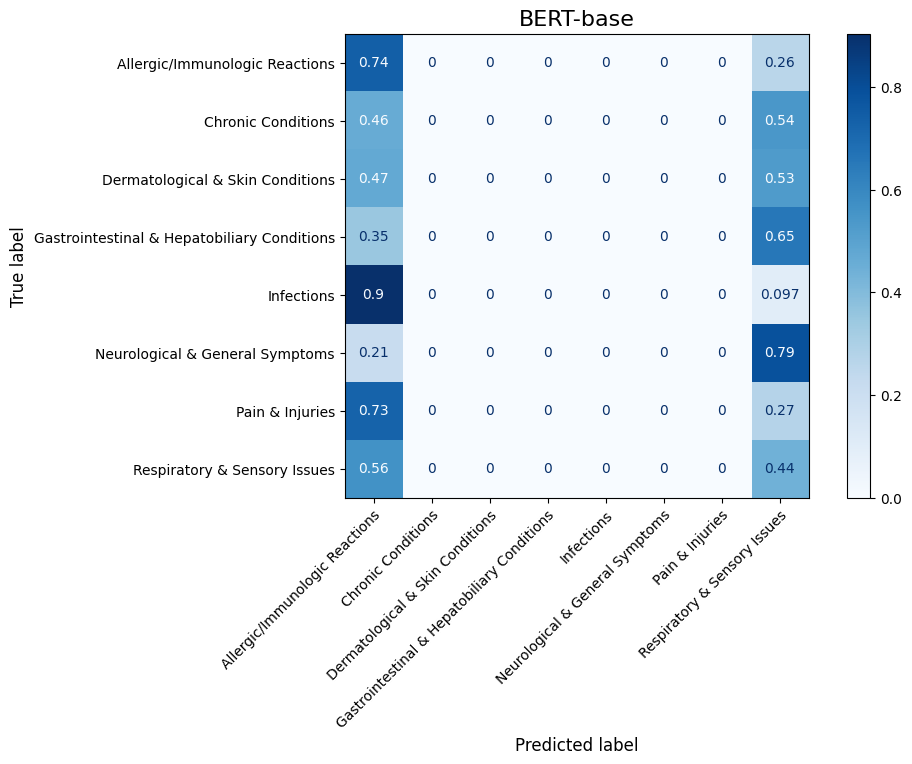

In [123]:
cm_bert = confusion_matrix(
    y_true,
    y_pred_bert,
    labels=list(label2id.values()),  # class indices like [0, 1, 2, ...]
    normalize="true",
)

fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_bert,
    display_labels=list(label2id.keys()),  # class names like ['Infections', ...]
)

disp.plot(ax=ax, cmap="Blues", xticks_rotation=0, colorbar=True)

# Set custom rotated tick labels
ax.set_xticklabels(
    list(label2id.keys()), rotation=45, ha="right", rotation_mode="anchor"
)

# Tight layout for spacing
plt.subplots_adjust(bottom=0.3)

# Add title and axis labels
ax.set_title("BERT-base", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)

plt.show()

plt.show()

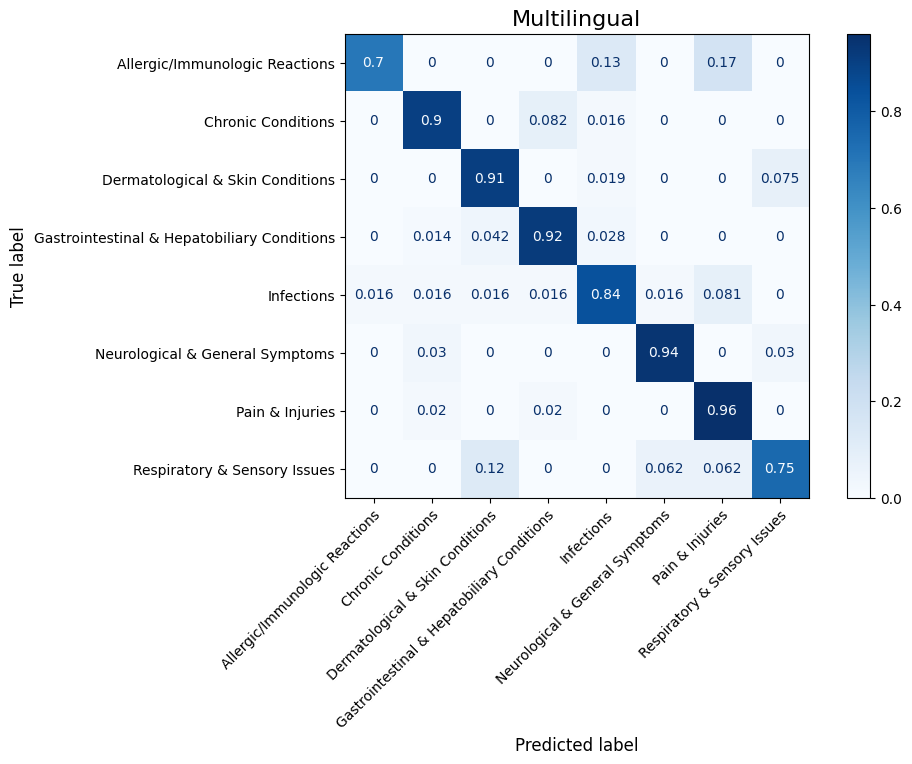

In [115]:
# Calculate confusion matrix for Multilingual model
cm_multi = confusion_matrix(
    y_true, y_pred_multi, labels=list(label2id.values()), normalize="true"
)

# Plot Multilingual confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp_multi = ConfusionMatrixDisplay(
    confusion_matrix=cm_multi, display_labels=list(label2id.keys())
)
disp_multi.plot(ax=ax, xticks_rotation=0, cmap="Blues", colorbar=True)

# Rotate and right-align the x-axis labels
ax.set_xticks(range(len(label2id)))
ax.set_xticklabels(
    list(label2id.keys()), rotation=45, ha="right", rotation_mode="anchor"
)

# Adjust layout so tick labels aren't cut off
plt.subplots_adjust(bottom=0.3)

# Set titles and labels
ax.set_title("Multilingual", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)

plt.show()

# F1 Score Comparison

In [118]:
from sklearn.metrics import classification_report
import pandas as pd

# Ensure both report calls include `labels=real_ids`
report_bert = classification_report(
    y_true, y_pred_bert, labels=real_ids, target_names=real_names, output_dict=True
)
report_multi = classification_report(
    y_true, y_pred_multi, labels=real_ids, target_names=real_names, output_dict=True
)

# Convert to DataFrames
df_bert = pd.DataFrame(report_bert).transpose().iloc[:-3]
df_multi = pd.DataFrame(report_multi).transpose().iloc[:-3]

# Combine
df_combined = pd.concat(
    [df_bert.add_suffix("_bert"), df_multi.add_suffix("_multi")], axis=1
)

# Show
print("Classification Report Comparison")
display(df_combined.round(3))

Classification Report Comparison


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site

,precision_bert,recall_bert,f1-score_bert,support_bert,precision_multi,recall_multi,f1-score_multi,support_multi
Neurological & General Symptoms,0.083,0.739,0.150,23.0,0.941,0.696,0.800,23.0
Dermatological & Skin Conditions,0.000,0.000,0.000,61.0,0.932,0.902,0.917,61.0
Chronic Conditions,0.000,0.000,0.000,53.0,0.889,0.906,0.897,53.0
Infections,0.000,0.000,0.000,72.0,0.904,0.917,0.910,72.0
Pain & Injuries,0.000,0.000,0.000,62.0,0.881,0.839,0.860,62.0
Gastrointestinal & Hepatobiliary Conditions,0.000,0.000,0.000,33.0,0.939,0.939,0.939,33.0
Respiratory & Sensory Issues,0.000,0.000,0.000,51.0,0.831,0.961,0.891,51.0
Allergic/Immunologic Reactions,0.042,0.438,0.077,16.0,0.706,0.750,0.727,16.0
NaN,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0


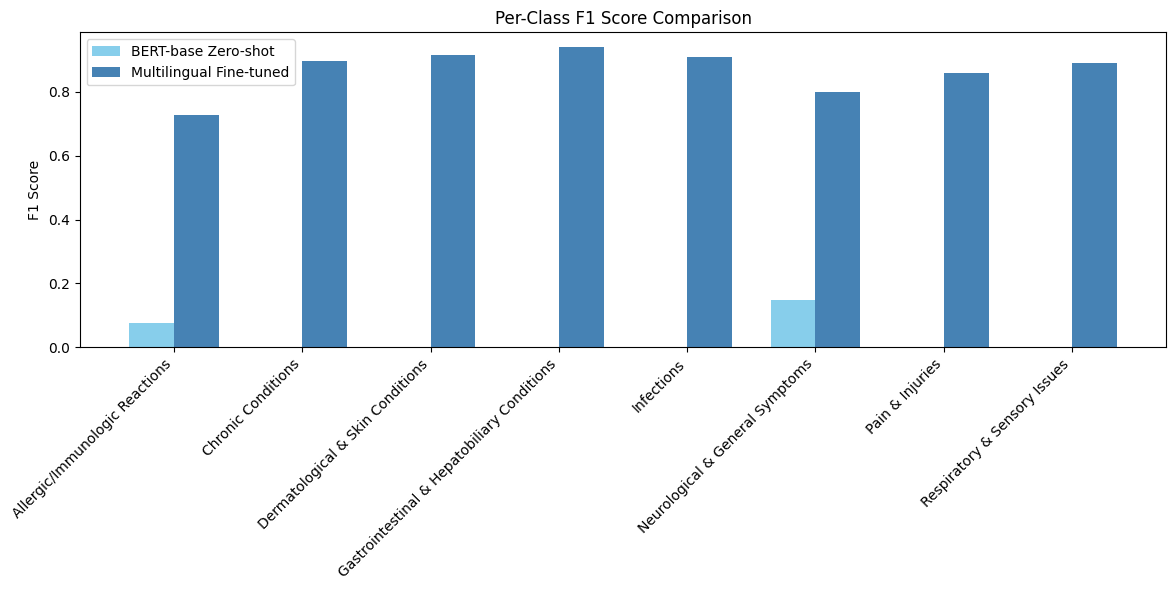

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Reindex to keep only clean_labels (no NaN)
df_cleaned = df_combined.loc[clean_labels]

# Extract F1-scores
f1_bert = df_cleaned["f1-score_bert"]
f1_multi = df_cleaned["f1-score_multi"]
labels = df_cleaned.index.tolist()

x = np.arange(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(
    x - width / 2, f1_bert, width, label="BERT-base Zero-shot", color="skyblue"
)
bars2 = ax.bar(
    x + width / 2, f1_multi, width, label="Multilingual Fine-tuned", color="steelblue"
)

# Customize
ax.set_ylabel("F1 Score")
ax.set_title("Per-Class F1 Score Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

# Training loss

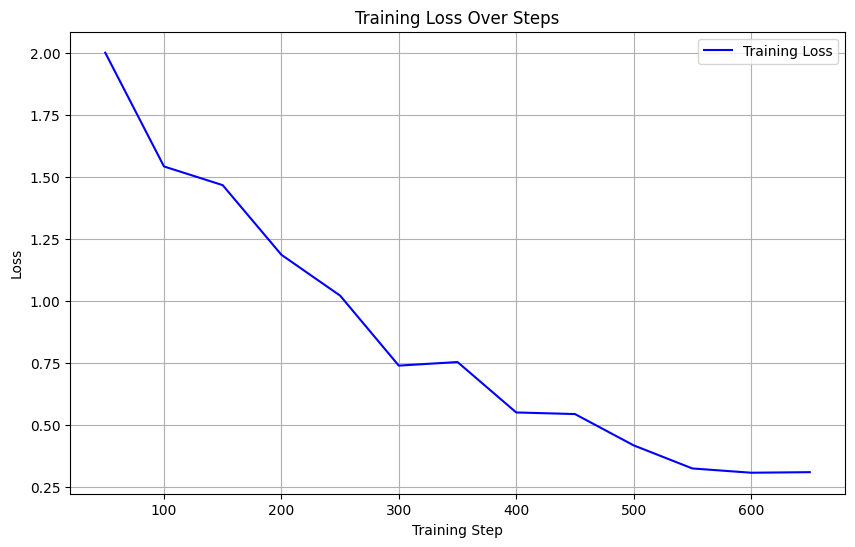

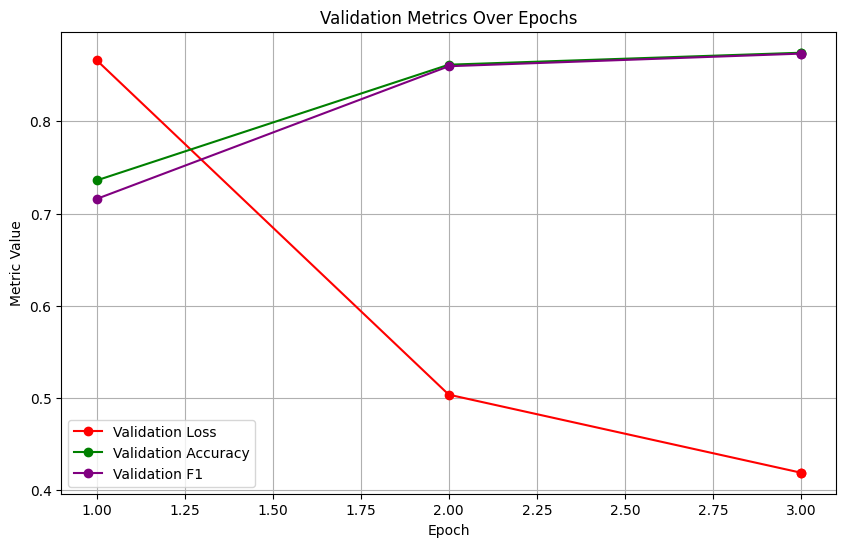

In [122]:
log_df = pd.DataFrame(trainer.state.log_history)

# --- Training loss over steps ---
train_logs = log_df[log_df["loss"].notna()]
plt.figure(figsize=(10, 6))
plt.plot(train_logs["step"], train_logs["loss"], label="Training Loss", color="blue")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()

# --- Validation metrics over epochs ---
eval_logs = log_df[log_df["eval_loss"].notna()]

plt.figure(figsize=(10, 6))
plt.plot(
    eval_logs["epoch"],
    eval_logs["eval_loss"],
    marker="o",
    label="Validation Loss",
    color="red",
)
plt.plot(
    eval_logs["epoch"],
    eval_logs["eval_accuracy"],
    marker="o",
    label="Validation Accuracy",
    color="green",
)
plt.plot(
    eval_logs["epoch"],
    eval_logs["eval_f1"],
    marker="o",
    label="Validation F1",
    color="purple",
)
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()